In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime
from dual import dual
from uniform import uniform
import ray
import logging
%matplotlib inline

In [2]:
EPSILON = 0.000001
def myround(num):
    num = num if abs(num) > EPSILON else 0
    return num

def get_return_probability(model_para, p, kernel):
    assert kernel in ['constant', 'sqrt', 'linear', "normal"]

    if kernel == "sqrt":
        m = model_para['m']
        return min(m * p ** (1 / 2), 1)
    elif kernel == "linear":
        a = model_para['a']
        b = model_para['b']
        return max((min(b, p) - a) / (b - a), 0)
    elif kernel == 'normal':
        # the Truncated Normal Distribution is used.
        mu = model_para['mu']
        std = model_para['std']
        return truncnorm.cdf(p, a=(0 - mu) / std, b=(1 - mu) / std, loc=mu, scale=std)

In [3]:
@ray.remote
def get_uniform_result(c, con, cr, rho, model_para, kernel, step, density):
    uniform_ins = uniform(c=c, con=con, rho=rho, model_para=model_para, cr=cr, kernel=kernel, step=step, density=density)
    return uniform_ins.p, uniform_ins.profit


@ray.remote
def get_dual_result(c, con, cr, rho, model_para, kernel, step, density):
    dual_ins = dual(c=c, con=con, rho=rho, model_para=model_para, cr=cr, step=step, kernel=kernel, density=density)
    return dual_ins.pon, dual_ins.poff, dual_ins.profit


def main(stds, filenames, plot=False, save=False, **kwargs):
    for std, filename in zip(stds, filenames):
        model_para = {"mu":0.0,"std":std}
        p_list = []
        piu_list = []

        pon_list = []
        poff_list = []
        pid_list = []

        rho =  kwargs["rho"]
        cr = kwargs["cr"]
        con = kwargs["con"]
        step = kwargs["step"]
        density = kwargs["density"]
        sel_c = kwargs["sel_c"]
        kernel =kwargs["kernel"]

        results_uniform_id = []
        results_dual_id = []

        for c in sel_c:
            results_uniform_id.append(
                get_uniform_result.remote(c=c, con=con, cr=cr, rho=rho,model_para=model_para, kernel=kernel,step=step, density=density))
            results_dual_id.append(
                get_dual_result.remote(c=c, con=con, cr=cr, rho=rho, model_para=model_para, kernel=kernel, step=step, density=density))

        results_uniform = ray.get(results_uniform_id)
        results_dual = ray.get(results_dual_id)

        for result_uniform, result_dual in zip(results_uniform, results_dual):
            p_list.append(result_uniform[0])
            piu_list.append(result_uniform[1])

            pon_list.append(result_dual[0])
            poff_list.append(result_dual[1])
            pid_list.append(result_dual[2])

        if plot:
            fig = plt.figure(figsize=(5, 8))
            ax1 = fig.add_subplot(2, 1, 1)
            ax1.plot(sel_c, piu_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax1.plot(sel_c, pid_list, c='blue', ls='--', ms=6, marker='o', label="Dual")

            ax2 = fig.add_subplot(2, 1, 2)
            ax2.plot(sel_c, p_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
            ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
                     label="Offline of Dual")

            ax1.legend(prop=dict(size=9), frameon=False)
            ax1.set_ylabel("Profits", fontsize=16)
            ax1.set_xlabel("c", fontsize=16)

            ax2.legend(prop=dict(size=9), frameon=False)
            ax2.set_ylabel("Prices", fontsize=16)
            ax2.set_xlabel("c", fontsize=16)

            plt.tight_layout()
            plt.show()
        if save:
            cols = ["c", "p_u", "pi_u", "pon", "poff", "pi_d"]
            data = np.array([sel_c, p_list, piu_list, pon_list, poff_list, pid_list]).T

            data_frame = pd.DataFrame(data=data, columns=cols)
            data_frame.to_excel(filename, index=False)

        logger.info("a work is finished...")

In [4]:
def plot(data, stds, fz=(20,8)):
    fig,axes = plt.subplots(2, len(data), sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    for j,current_data  in enumerate(data):
        sel_c = current_data["c"]
        min_c_ind = min(sel_c)
        max_c_ind = max(sel_c)
        step = sel_c[1]-sel_c[0]

        sel_prices_u = current_data["p_u"]
        sel_prices_d_on =  current_data["pon"]
        sel_prices_d_off =  current_data["poff"]


        axes[0,j].plot(sel_c, sel_prices_u, c='red', ls='--', ms=6, marker='^', markerfacecolor='none',label="Uniform")
        axes[0,j].plot(sel_c, sel_prices_d_on, c='blue', ls='--', ms=6, marker='o',  markerfacecolor='none',label="Online of Dual")
        axes[0,j].plot(sel_c, sel_prices_d_off, c='green', ls='--', ms=6, marker='D',
                 markerfacecolor='none',label="Offline of Dual")

        axes[0,j].legend(prop=dict(size=12), frameon=False)

        #axes[0,j].set_xlabel("c", fontsize =16)

        axes[0,j].set_title(r"$std$={} ".format(stds[j]), fontsize=22)
#         axes[0,j].set_xlim((0.1,0.17))
#         axes[0,j].set_ylim((0.28,0.46))
        
        for label in (axes[0,j].get_xticklabels() + axes[0,j].get_yticklabels()):
            label.set_fontsize(16)

        sel_profits_u = current_data["pi_u"]
        sel_profits_d = current_data["pi_d"]

        axes[1,j].plot(sel_c, sel_profits_u,c='red', ls='--', ms=6, marker='^', markerfacecolor='none', label="Uniform")
        axes[1,j].plot(sel_c, sel_profits_d,c='blue', ls='--', ms=6, marker='o',markerfacecolor='none',label="Dual")

        axes[1,j].legend(prop=dict(size=12), frameon=False)
#         axes[1,j].set_ylim((0.03,0.042))
#         axes[1,j].set_xlim((0.1,0.17))
        
        for label in (axes[1,j].get_xticklabels() + axes[1,j].get_yticklabels()):
            label.set_fontsize(16)
    axes[0,0].set_ylabel("Prices", fontsize =22)
    axes[1,0].set_ylabel("Profits", fontsize =22)
    fig.text(0.5, 0, 'c', ha='center',fontsize =22)
    fig.tight_layout()
    return fig

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 56 seconds


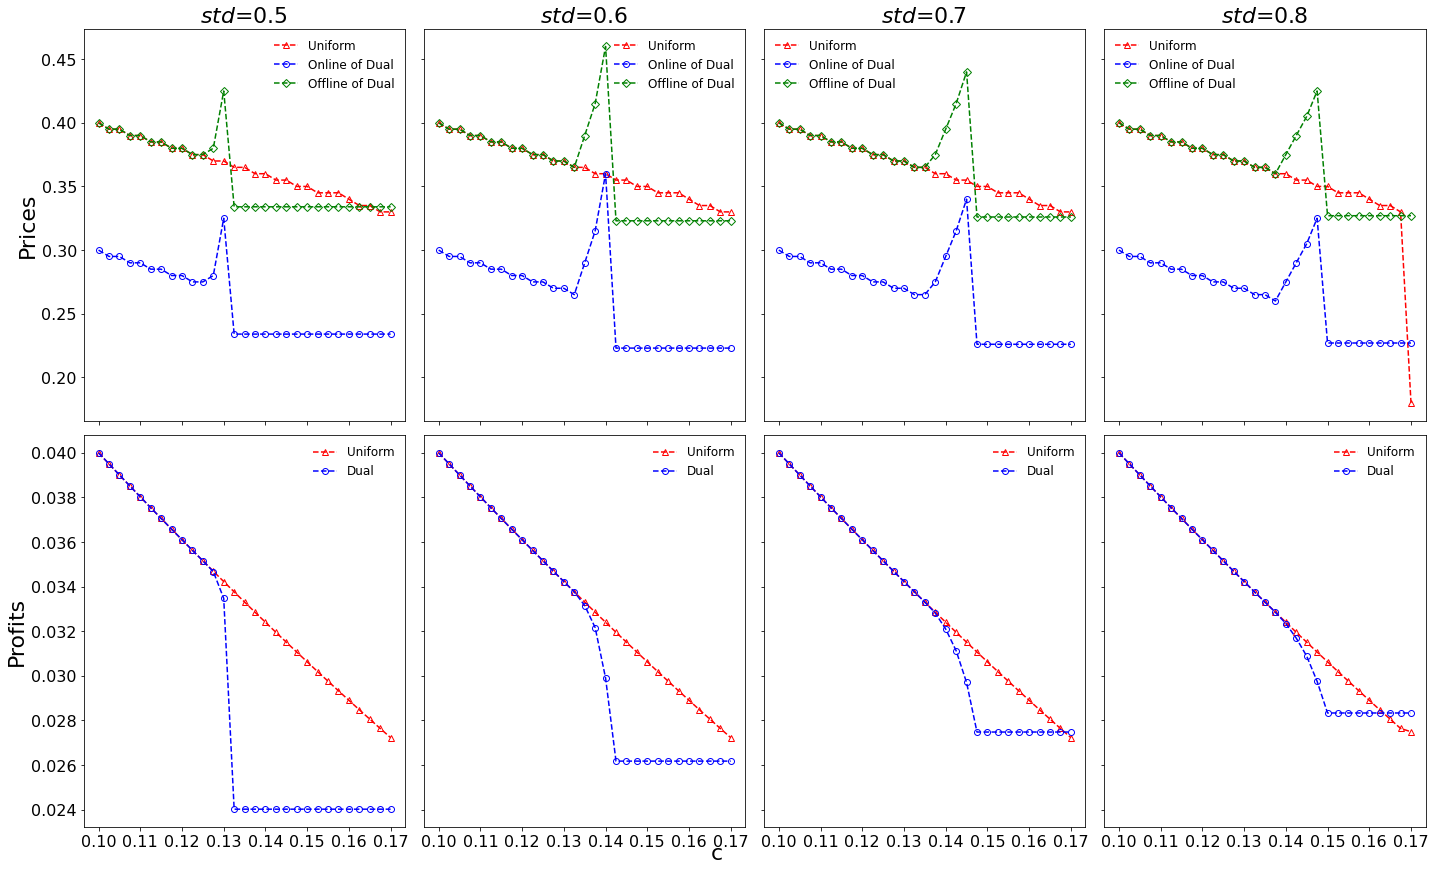

In [5]:
logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
stds = [0.5, 0.6, 0.7,0.8] 
filenames = []
for ind, std in enumerate(stds):
    filenames.append("norm_return_rate_"+str(ind)+".xlsx")

rho=0
cr = 0.4
con = 0.1
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.17, 0.0025)
kernel="normal"
input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(stds=stds, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))
myfig = plot(data, stds=stds, fz=(20,12))

## The impact of rho

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 47 seconds


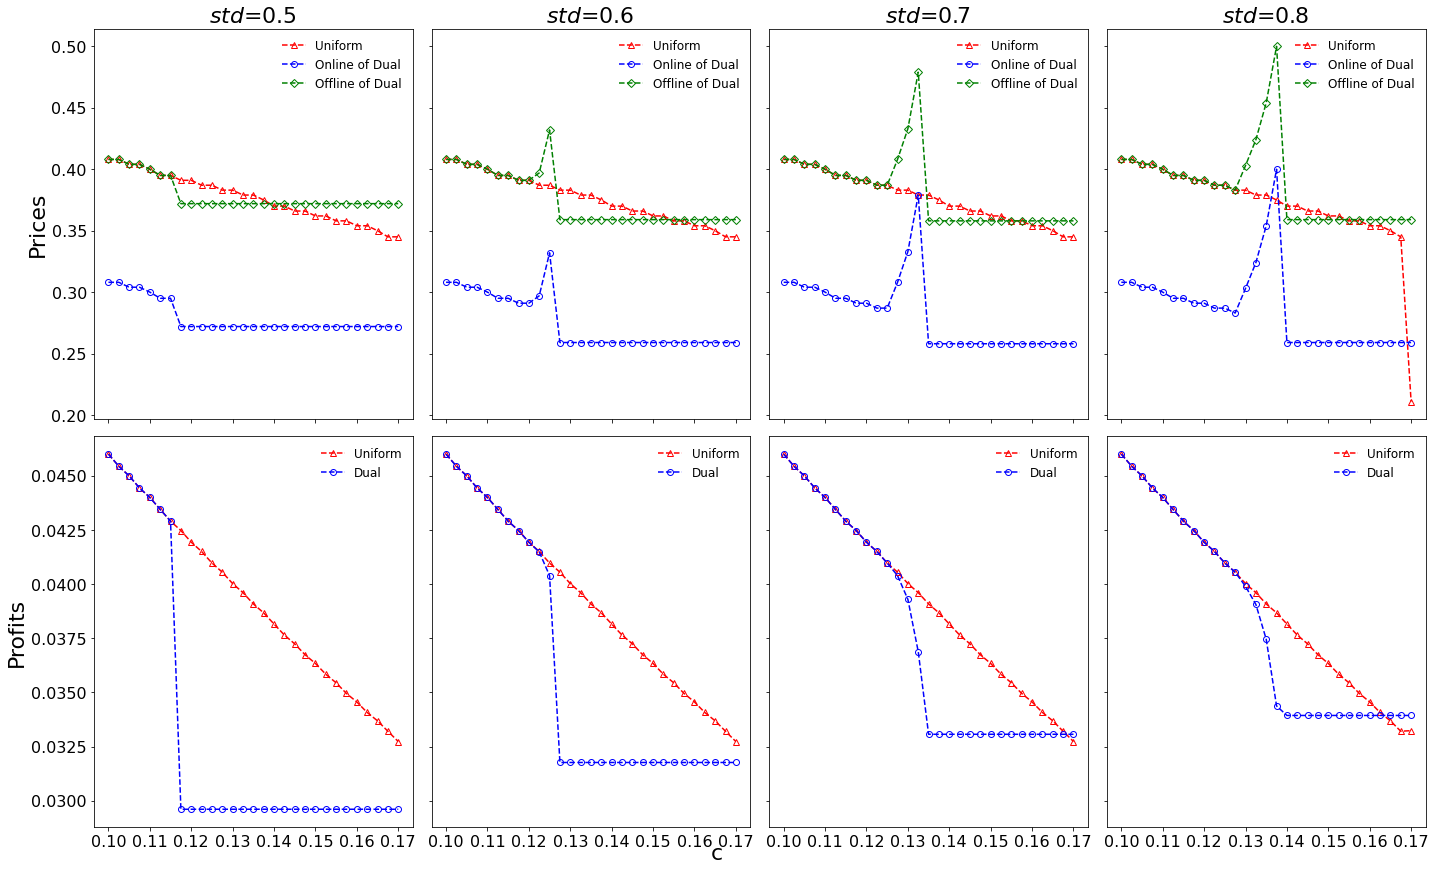

In [6]:
logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
stds = [0.5, 0.6, 0.7,0.8] 
filenames = []
for ind, std in enumerate(stds):
    filenames.append("norm_return_rate_"+str(ind)+".xlsx")

rho=0.1
cr = 0.4
con = 0.1
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.17, 0.0025)
kernel="normal"
input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(stds=stds, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))
myfig = plot(data, stds=stds, fz=(20,12))

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 48 seconds


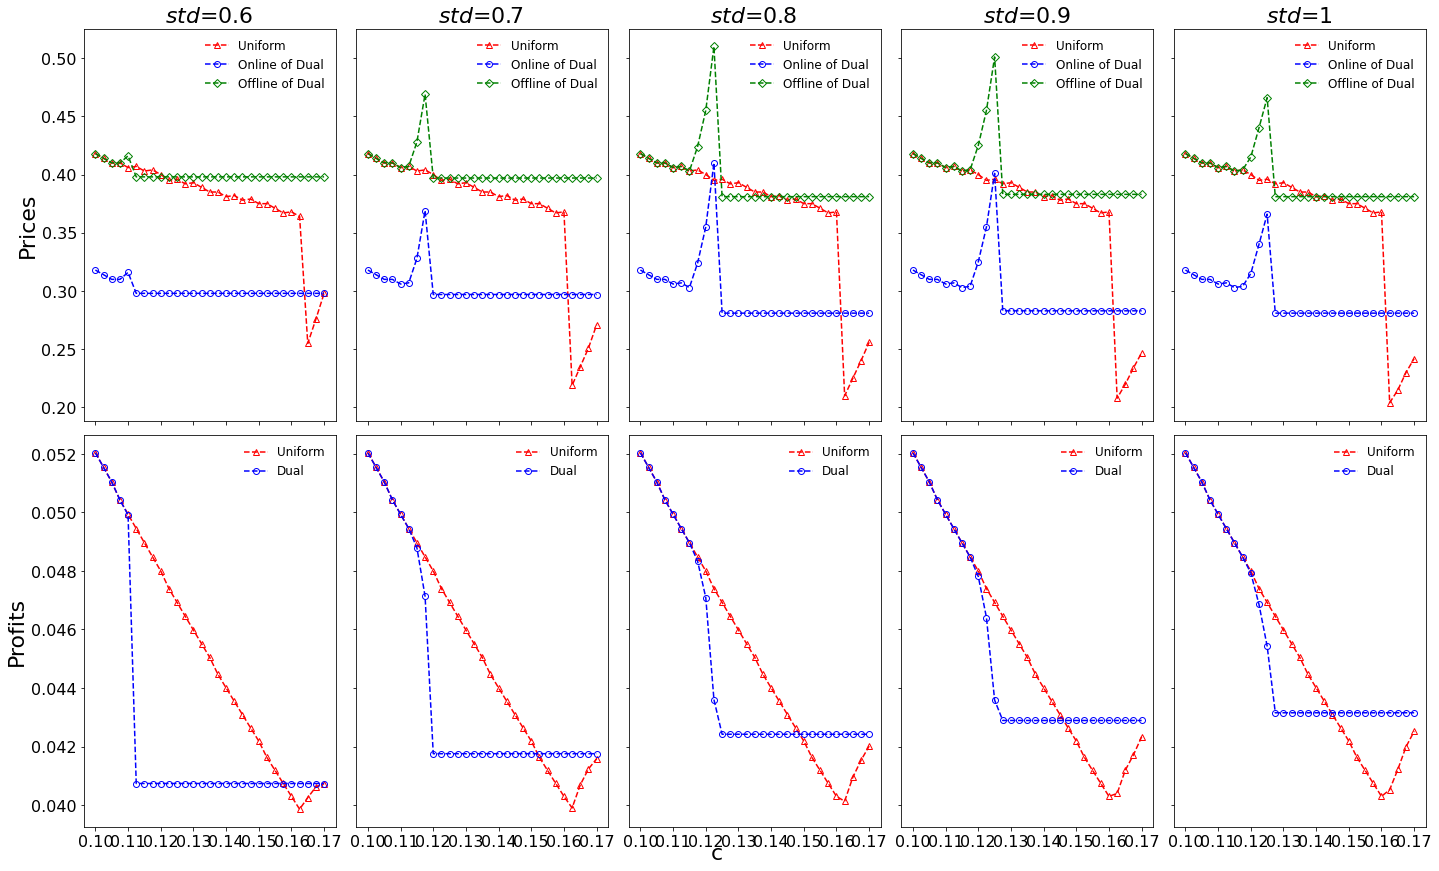

In [11]:
logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
stds = [0.6, 0.7,0.8, 0.9, 1] 
filenames = []
for ind, std in enumerate(stds):
    filenames.append("norm_return_rate_"+str(ind)+".xlsx")

rho=0.2
cr = 0.32
con = 0.1www
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.17, 0.0025)
kernel="normal"
input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(stds=stds, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))
myfig = plot(data, stds=stds, fz=(20,12))